In [ ]:
!pip install transformers torch pandas matplotlib seaborn scikit-learn tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.0 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "xlm-roberta-base"

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item


In [ ]:
import torch.nn as nn

class TransformerClassifier(nn.Module):
    def __init__(self, model_name):
        super(TransformerClassifier, self).__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output).squeeze(-1)

In [ ]:
def evaluate_transformer_model(model_path, data_path, max_len=256, batch_size=16, category_col='category'):
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    df = pd.read_csv(data_path).dropna()

    texts = df['text'].tolist()
    labels = df['label'].values
    categories = df[category_col].values

    dataset = TextDataset(texts, labels, tokenizer, max_len)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    model = TransformerClassifier(MODEL_NAME)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels_batch = batch['labels'].to(DEVICE)

            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).int()

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, zero_division=0))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix for RoBERTa - Raw Data Extreme Cases Dataset")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve for RoBERTa - Raw Data Extreme Cases Dataset")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    correct_mask = (all_preds == all_labels)
    correct_categories = categories[correct_mask]

    unique_cats = sorted(np.unique(categories))
    counts = [np.sum(correct_categories == cat) for cat in unique_cats]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=unique_cats, y=counts, palette="magma")
    plt.xlabel("Case Category")
    plt.ylabel("Correct Predictions")
    plt.title("Correct Predictions per Category for RoBERTa Transformer Model")
    plt.grid(True, axis='y')
    plt.xticks(ticks=range(len(unique_cats)), labels=[str(c) for c in unique_cats])

    for i, count in enumerate(counts):
        plt.text(i, count + 0.2, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.show()

    print("\n--- Summary of Correct Predictions per Category ---")
    for cat in unique_cats:
        total = np.sum(categories == cat)
        correct = np.sum((categories == cat) & (all_preds == all_labels))
        print(f"Kategoria {cat}: poprawnie {correct} na {total}")

Evaluating: 100%|██████████| 11/11 [02:07<00:00, 11.59s/it]

Accuracy:  0.2816
Precision: 0.4828
Recall:    0.2276
F1-score:  0.3094
ROC AUC:   0.2732

Classification Report:
               precision    recall  f1-score   support

         0.0       0.18      0.41      0.25        51
         1.0       0.48      0.23      0.31       123

    accuracy                           0.28       174
   macro avg       0.33      0.32      0.28       174
weighted avg       0.39      0.28      0.29       174



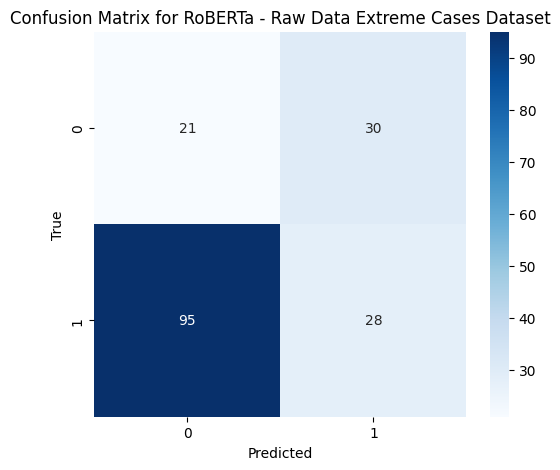

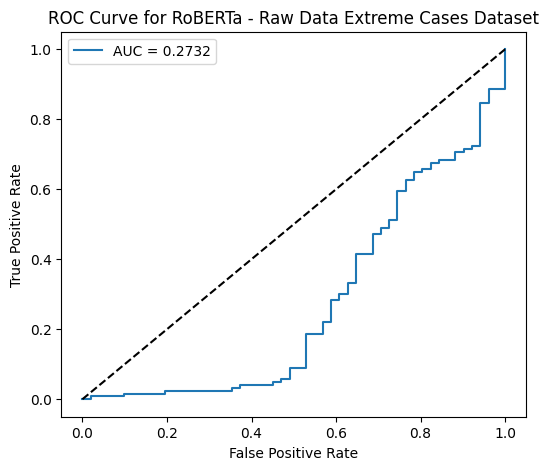

<ipython-input-7-829ccf442f7e>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_cats, y=counts, palette="magma")


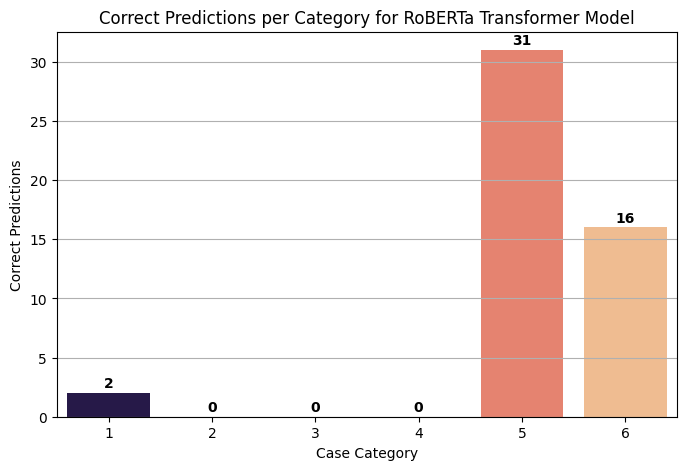


--- Summary of Correct Predictions per Category ---
Kategoria 1: poprawnie 2 na 24
Kategoria 2: poprawnie 0 na 25
Kategoria 3: poprawnie 0 na 25
Kategoria 4: poprawnie 0 na 25
Kategoria 5: poprawnie 31 na 50
Kategoria 6: poprawnie 16 na 25


In [ ]:
evaluate_transformer_model(
    model_path="best_model.pt", 
    data_path="extreme_examples_raw.csv", 
    max_len=256,
    batch_size=16                     
)